# 'How to Build a Gradient Boosting Machine from Scratch'

> Intuitively understand the gradient boosting machine and implement one from scratch.

- hide: true

Ahh, gradient boosting.  In addition to having a totally kickass name, this family of machine learning algorithms is currently among the best known approaches for prediction problems on structured data. Like its cousin random forest, gradient boosting is a tree ensemble technique that generates a single strong model by combining many simple decision trees. These tree ensemble methods perform very well on tabular data prediction problems and are therefore widely used in industrial applications and machine learning competitions. 

There are several noteworthy variants of gradient boosting out there in the wild including [XGBoost](https://xgboost.readthedocs.io/en/latest/), [NGBoost](https://stanfordmlgroup.github.io/projects/ngboost/), [LightGBM](https://lightgbm.readthedocs.io/en/latest/), and of course the classic [gradient boosting machine](https://en.wikipedia.org/wiki/Gradient_boosting) (GBM). While XGBoost and LightGBM tend to have a marginal performance edge on the classic GBM, they are all based on a similar, very clever, idea about how to ensemble decision trees. Let's avail ourselves of the intuition behind that clever idea, and then we'll be able to build our very own GBM from scratch.


In [17]:
#hide
import numpy as np 
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot as plt 

%matplotlib inline

## Toy Data

We begin our boosting adventure with a deceptively simple toy dataset having one feature $x$ and target $y$.

In [18]:
#hide
import numpy as np 

rng = np.random.default_rng()
x = np.linspace(0, 10, 50)
y = np.where(x < 5, x, 5) + rng.normal(0, 0.4, size=x.shape)
x = x.reshape(-1,1)

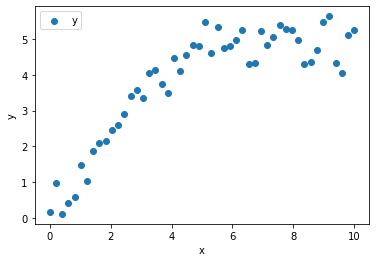

In [19]:
#hide_input
plt.scatter(x,y, label='y')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

Notice that $y$ increases with $x$ for a while, then flattens out.
This is a pattern that happens all the time in real data, and it's one that linear models epically fail to capture.
Let's build a gradient boosting machine to model it.


## Intuition

Suppose we have a crappy model $F_0(x)$ that uses features $x$ to predict target $y$.
A crappy but reasonable choice of $F_0(x)$ would be a model that always predicts the mean of $y$.

$$F_0(x) = \bar{y}$$

That would look like this.

In [20]:
#hide
eta = 1

F_0 = y.mean() * np.ones(shape=y.shape)

h_1 = DecisionTreeRegressor(max_depth=1)
h_1.fit(x, y - F_0)
F_1 = F_0 + eta * h_1.predict(x)

h_2 = DecisionTreeRegressor(max_depth=1)
h_2.fit(x, y - F_1)
F_2 = F_1 + eta * h_2.predict(x)

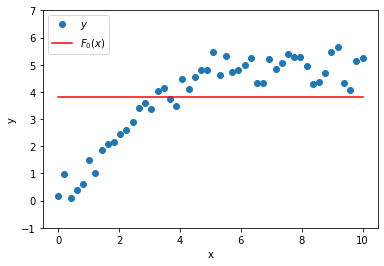

In [21]:
#hide_input
plt.plot(x, y, 'o', label=r'$y$')
plt.plot(x, F_0, '-r', label=r'$F_0(x)$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.ylim([-1,7]);

$F_0(x)$ by itself is not a great model, so its residuals $y - F_0(x)$ are still pretty big and they still exhibit meaningful structure that we should try to capture with our model.

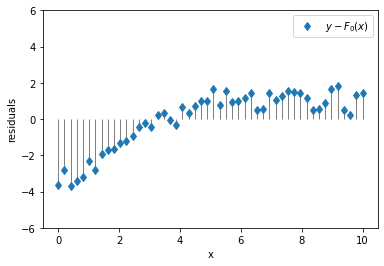

In [22]:
#hide_input
fig, ax = plt.subplots()
ax.plot(x, y - F_0, 'd', label=r'$y - F_0(x)$')
ax.vlines(x, 0, y - F_0, linewidth=0.5)
# plt.plot(x, h_1.predict(x), '--r', label=r'$h_1(x)$')
plt.xlabel('x')
plt.ylabel('residuals')
ax.legend()
ax.set_ylim([-6, 6]);

Well what if I had another crappy model $h_1(x)$ that could predict the residuals $y - F_0(x)$?

$$
\begin{array}{rcl}
\text{Model: }& & h_1(x) \\
\text{Features:}& & x \\
\text{Target:}& & y - F_0(x)
\end{array}
$$

It's worth noting that the crappiness of this new model is essential; in fact in this boosting context, it's usually  called a _weak learner_.
To get a model that's only slightly better than nothing, let's use a very simple [decision tree](https://en.wikipedia.org/wiki/Decision_tree_learning) with a single split, a.k.a. a stump. 
This model basically divides our feature $x$ into two  regions and predicts the mean value of $y$ for all of the $x$'s in each region. It might look like this.

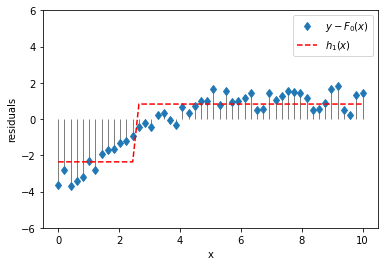

In [23]:
#hide_input
fig, ax = plt.subplots()
ax.plot(x, y - F_0, 'd', label=r'$y - F_0(x)$')
ax.vlines(x, 0, y - F_0, linewidth=0.5)
plt.plot(x, h_1.predict(x), '--r', label=r'$h_1(x)$')
plt.xlabel('x')
plt.ylabel('residuals')
ax.legend()
ax.set_ylim([-6, 6]);

We could make a composite model by adding the predictions of the base model $F_0(x)$ to the predictions of the supplemental model $h_1(x)$ (which will pick up some of the slack left by $F_0(x)$). We'd get a new model $F_1(x)$:

$$F_1(x) = F_0(x) + h_1(x)$$

which iss better at predicting $y$ than the original model $F_0(x)$ alone.

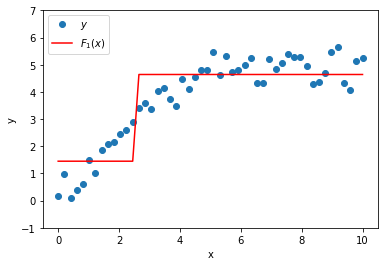

In [24]:
#hide_input
plt.plot(x, y, 'o', label=r'$y$')
plt.plot(x, F_1, '-r', label=r'$F_1(x)$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.ylim([-1,7]);

Why stop there? Our composite model $F_1(x)$ might still be kind of crappy, and so its residuals $y - F_1(x)$ might still be pretty big and structurey. Let's add another model $h_2(x)$ to predict those residuals.

$$
\begin{array}{rcl}
\text{Model: }& & h_2(x) \\
\text{Features:}& & x \\
\text{Target:}& & y - F_1(x)
\end{array}
$$

The new composite model is

$$F_2(x) = F_1(x) + h_2(x).$$

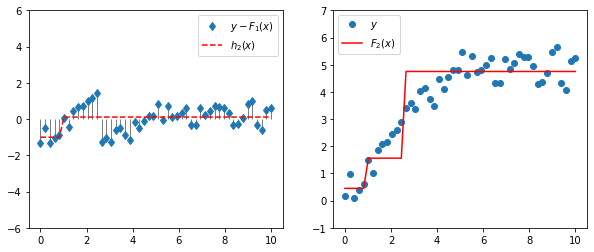

In [25]:
#hide_input

# m = 2

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(x, y - F_1, 'd', label=r'$y - F_1(x)$')
ax[0].vlines(x, 0, y - F_1, linewidth=0.5)
ax[0].plot(x, h_2.predict(x), '--r', label=r'$h_2(x)$')
ax[0].legend()
ax[0].set_ylim([-6, 6])

ax[1].plot(x, y, 'o', label=r'$y$')
ax[1].plot(x, F_2, '-r', label=r'$F_2(x)$')
ax[1].legend()
ax[1].set_ylim([-1,7]);

If we keep doing this, at each stage we'll train a new model $h_m(x)$ on the residuals from the previous composite model $F_{m-1}(x) - y$, and we'll get a new composite model

$$F_m(x) = F_{m-1}(x) + h_m(x).$$

If we add $M$ crappy models constructed in this way  to our original crappy model $F_0(x)$, we might actually end up with a pretty good model $F_M(x)$ that looks like

$$
F_M(x) = F_0(x) + \sum_{m = 1}^{M} h_m(x)
$$


Here's how our model would evolve up to $M=6$.

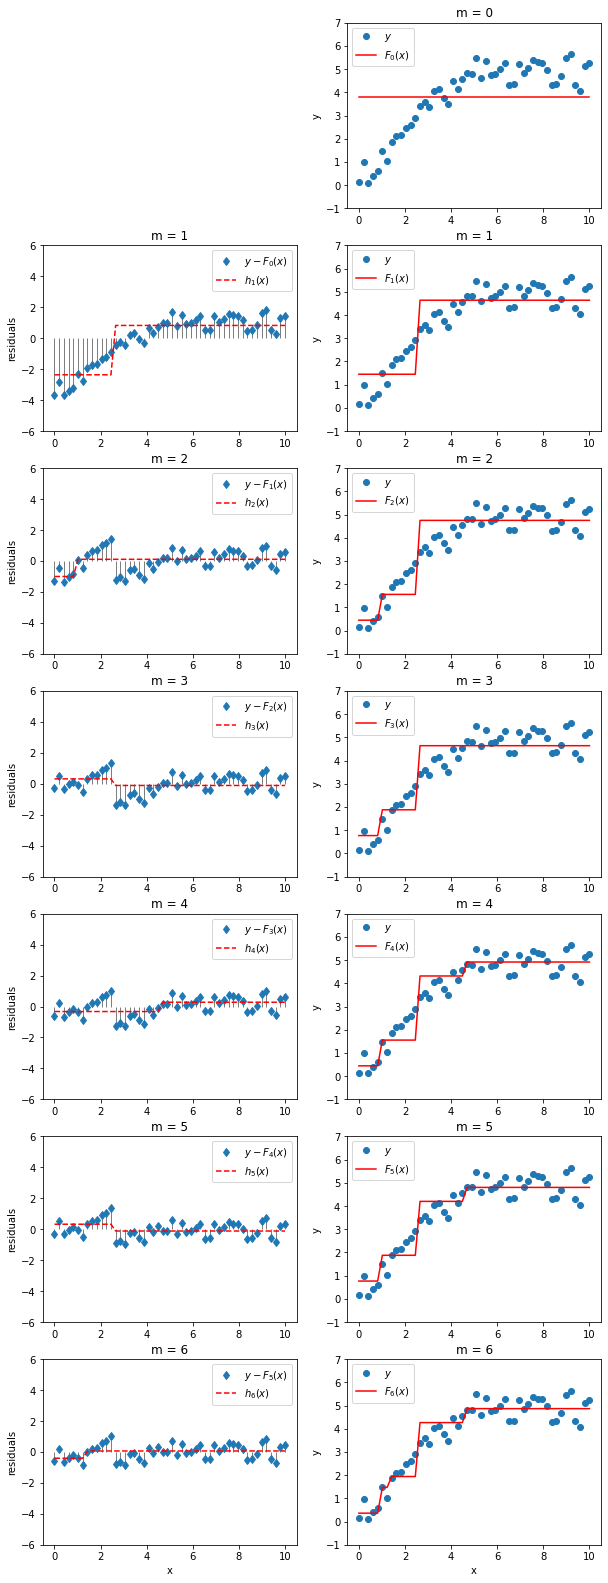

In [26]:
#hide_input
# hyperparameters
learning_rate = 1
n_trees = 6
max_depth = 1

# Training
F0 = y.mean() 

fig, ax = plt.subplots(7,2, figsize=(10,28))

ax[0,0].axis('off')
ax[0,1].plot(x, y, 'o', label=r'$y$')
ax[0,1].plot(x, F_0, '-r', label=r'$F_0(x)$')
ax[0,1].set_title('m = 0')
ax[0,1].set_ylabel('y')
ax[0,1].legend()
ax[0,1].set_ylim([-1,7]);

Fm = F0
trees = []
for i in range(n_trees):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(x, y - Fm)

    m = i + 1
    
    ax[m,0].plot(x, y - Fm, 'd', label=r'$y - F_{}(x)$'.format(m-1))
    ax[m,0].vlines(x, 0, y - Fm, linewidth=0.5)
    ax[m,0].plot(x, tree.predict(x), '--r', label=r'$h_{}(x)$'.format(m))
    ax[m,0].legend()
    ax[m,0].set_ylim([-6, 6])
    ax[m,0].set_title('m = {}'.format(m))
    ax[m,0].set_ylabel('residuals')

    Fm += learning_rate * tree.predict(x)
    trees.append(tree)
    
    ax[m,1].plot(x, y, 'o', label=r'$y$')
    ax[m,1].plot(x, Fm, '-r', label=r'$F_{}(x)$'.format(m))
    ax[m,1].legend()
    ax[m,1].set_ylim([-1,7])
    ax[m,1].set_title('m = {}'.format(m))
    ax[m,1].set_ylabel('y')

ax[m,0].set_xlabel('x')
ax[m,1].set_xlabel('x');

Voila! That, friends, is boosting!

## Learning Rate

Let's talk about overfitting.
In real life, if we just add our new weak learner $h_m(x)$ directly to our existing composite model $F_{m-1}(x)$, then we're likely to end up overfitting on our training data. That's because if we add enough of these weak learners, they're going to chase down y so closely that all the remaining residuals are pretty much zero, and we will have successfully memorized the training data. To prevent that, we'll scale them down a bit by a parameter $\eta$ called the learning rate. 

With the learning rate $\eta$, the update step will then look like

$$F_{m}(x) = F_{m-1}(x) + \eta h_m(x),$$

and our composite  model will look like

$$
F_M(x) = F_0(x) + \eta \sum_{m = 1}^{M} h_m(x})
$$


Note that since the learning rate can be factored out of the sum, it looks kinda like we could just build our models without it and slap it on at the end when we sum up the weak learners to make the final composite model. But that won't work, since at each stage we train the next weak learner on the residuals from the current composite model, and the current composite model depends on the learning rate.

## Implementation

Ok, we're ready to implement this thing from "scratch". Well, sort of. To quote Carl Sagan,

> youtube: https://youtu.be/7s664NsLeFM

> If you wish to make an apple pie from scratch, you must first invent the universe.

We will not be inventing a universe that contains the Earth, apple trees, computers, python, numpy, and sklearn. To keep the "scratch" implementation clean, we'll allow ourselves the luxury of numpy and an off-the-shelf sklearn decision tree which we'll use as our weak learner.


In [27]:
from sklearn.tree import DecisionTreeRegressor

# model hyperparameters
learning_rate = 0.3
n_trees = 10
max_depth = 1

# Training
F0 = y.mean() 
Fm = F0
trees = []
for _ in range(n_trees):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(x, y - Fm)
    Fm += learning_rate * tree.predict(x)
    trees.append(tree)

# Prediction
y_hat = F0 + learning_rate * np.sum([t.predict(x) for t in trees], axis=0)

We first define our hyperparameters: 
- `learning_rate` is ($\eta$)
- `n_trees` is the number of weak learner trees to add ($M$)
- `max_depth` controls the depth of the trees; here we set to 1 for stumps

We define our base model predictions `F0` to simply predict the mean value of `y`.
`Fm` corresponds to the current composite model  $F_m(x)$ as we iteratively add weak learners, so we'll initialize it with `F0`.
`trees` is an empty list that we'll use to hold our weak learners.

Next we iteratively add `n_trees` weak learners to our composite model.
At each iteration, we create a new decision tree and train it on `x` to predict the current residuals `y - Fm`.
We update `Fm` with the newly trained learner's predictions scaled by the learning rate, and we append the new weak learner $h_m(x)$ in the `trees` list.
We generate final predictions `y_hat` on the training data by summing up the predictions from each weak learner, scaling by the learning rate, and adding to the base model (a.k.a. the mean of `y`).



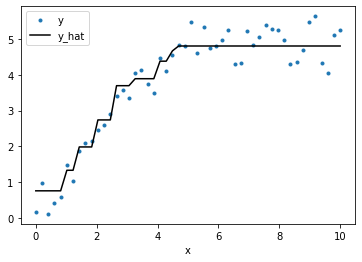

In [28]:
#hide_input
plt.plot(x,y,'.', label='y')
plt.plot(x,y_hat,'-k', label='y_hat')
plt.legend()
plt.xlabel('x');

Nice! Our GBM fits that nonlinear data pretty well.

Now that we have a working implementation, let's go ahead and implement it as a class with `fit` and `predict` methods like we're useed to having in sklearn.


In [29]:
class GradientBoostingFromScratch():
    
    def __init__(self, n_trees, learning_rate, max_depth=1):
        self.n_trees=n_trees; self.learning_rate=learning_rate; self.max_depth=max_depth;
        
    def fit(self, x, y):
        self.trees = []
        self.F0 = y.mean()
        Fm = self.F0 
        for _ in range(self.n_trees):
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(x, y - Fm)
            Fm += self.learning_rate * tree.predict(x)
            self.trees.append(tree)
            
    def predict(self, x):
        return self.F0 + self.learning_rate * np.sum([tree.predict(x) for tree in self.trees], axis=0)

Let's compare the performance of our implementation with the sklearn [`GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html).

In [30]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

sklearn_gbm = GradientBoostingRegressor(n_estimators =25, learning_rate=0.3, max_depth=1)
sklearn_gbm.fit(x,y)

scratch_gbm = GradientBoostingFromScratch(n_trees=25, learning_rate=0.3, max_depth=1)
scratch_gbm.fit(x,y)

mean_squared_error(y, sklearn_gbm.predict(x)), mean_squared_error(y, scratch_gbm.predict(x))

(0.10740933643265559, 0.10740933643265561)

Heck yeah! Our homemade GBM is consistent with the sklearn implementation!

## Wrapping Up

Alright, there you have it, the intuition behind basic gradient boosting and a from scratch implementation of the gradient boosting machine.
I tried to keep this explanation as simple as possible while giving a complete intuition for the basic GBM.
But it turns out that the rabbit hole goes pretty deep on these gradient boosting algorithms.
We can actually wave our magic generalization wand over some custom loss functions  and end up with algorithms that can do gradient descent in function space (whatever that means).
We'll get into what that means and why it's so baller in future posts.
For now, go forth and gradient boost!